In [1]:
import sys
import numpy as np
import pandas as pd
import scipy as sc
from scipy.stats import mannwhitneyu, zscore, ttest_ind, ttest_ind_from_stats, \
                        f_oneway, wilcoxon, kruskal, friedmanchisquare
from statsmodels.stats import weightstats as stests
import matplotlib.pyplot as plt

sys.path.append("../")

from src.ab.helpers import min_sample_size_avg

%matplotlib inline

MDE = 0.02
beta = 0.2
alpha = 0.07

In [2]:
class LogNormalGenerator():
    def __init__(self,
                 mean,
                 std):
        self.mean = mean
        self.std = std
    def get_sample(self,
                   size):
        return np.random.lognormal(mean=self.mean, 
                                   sigma=self.std, 
                                   size=size)*1000

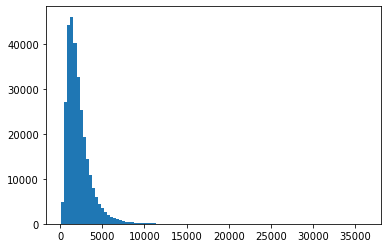

Mean and std on historical data: 2180.117702318025, 1432.5307271337122
Recommended sample size: 15200


In [3]:
mu, sd = 0.6, 0.6
generator = LogNormalGenerator(mean=mu,
                               std=sd)
retro_data = generator.get_sample(size=300000)
plt.hist(retro_data,
         bins=100)
plt.show()
sample_mean, sample_std = retro_data.mean(), retro_data.std()
print("Mean and std on historical data: {}, {}".format(sample_mean, sample_std))
#calc estimated sample size
sample_size = int(min_sample_size_avg(sample_std,
                                      retro_data.mean()*MDE,
                                      power=1-beta,
                                      sig_level=alpha))
print("Recommended sample size: {}".format(sample_size))

In [12]:
def check_stat_errors(size_A,
                      size_B,
                      n_experiments,
                      MDE):
    #generate experiment data
    experiment_data = np.array([[generator.get_sample(size=size_A), 
                                 generator.get_sample(size=size_B)] for i in range(n_experiments)])
    #data + effect 
    add_effects = lambda x: np.array([np.array([i[0], 
                                                i[1]+np.random.normal(i[1].mean() * MDE,
                                                                      i[1].std() / 10,
                                                                      len(i[1]))]) for i in x])
    experiment_data_effect_added = add_effects(experiment_data)
    
    #define some useful functions
    
    def calc_all_criterias(x, y):
        tt_pval = ttest_ind(a=x, b=y, equal_var=True, alternative='two-sided')[1]
        mw_pval = mannwhitneyu(x=x, y=y, alternative='two-sided').pvalue
        if len(x)!=len(y):
            wilcoxon_pval = -1
        else:
            wilcoxon_pval = wilcoxon(x, y, alternative='two-sided')[1]
        return [tt_pval, mw_pval, wilcoxon_pval]
        
    stat_calc = lambda x: np.array([np.array(calc_all_criterias(i[0], i[1])) for i in x])
    p_values = stat_calc(experiment_data)
    #calc i type errors
    i_type_calc = lambda x: [len(i[i<alpha])/len(i) for i in x]
    i_type_errors = i_type_calc(p_values.T)
    #calc ii type errors
    p_values_ii_type_error = stat_calc(experiment_data_effect_added)
    ii_type_calc = lambda x: [len(i[i>alpha])/len(i) for i in x]
    ii_type_errors = ii_type_calc(p_values_ii_type_error.T)
    
    return i_type_errors+ii_type_errors

#### Errors vs sample size

In [5]:
n_experiments = 1000
start = 100
if sample_size < 2000:
    step = 200
elif sample_size >= 2000 and sample_size< 10000:
    step = 200
elif sample_size >= 10000 and sample_size< 30000:
    step = 300
else:
    step=1000
num=int(sample_size/step)+3

sizes=np.arange(0,num)*step+start
error_per_sample_size = []

for size in sizes:
    print(size)
    i_type_error_tt, i_type_error_mw, i_type_wilcoxon, \
    ii_type_error_tt, ii_type_error_mw, ii_type_wilcoxon = check_stat_errors(size_A=size,
                                                                             size_B=size,
                                                                             n_experiments=n_experiments,
                                                                             MDE=MDE)
    error_per_sample_size.append([size, sample_size, i_type_error_tt, i_type_error_mw, \
                                  i_type_wilcoxon, \
        ii_type_error_tt, ii_type_error_mw, ii_type_wilcoxon])

100
400
700
1000
1300
1600
1900
2200
2500
2800
3100
3400
3700
4000
4300
4600
4900
5200
5500
5800
6100
6400
6700
7000
7300
7600
7900
8200
8500
8800
9100
9400
9700
10000
10300
10600
10900
11200
11500
11800
12100
12400
12700
13000
13300
13600
13900
14200
14500
14800
15100
15400
15700


In [6]:
res = pd.DataFrame(error_per_sample_size, columns = ['size', 'recommended_sample_size', 'i_type_error_tt', 'i_type_error_mw', \
                                  'i_type_wilcoxon', \
                                    'ii_type_error_tt', 'ii_type_error_mw', \
                                                     'ii_type_wilcoxon'] )
res

,size,recommended_sample_size,i_type_error_tt,i_type_error_mw,i_type_wilcoxon,ii_type_error_tt,ii_type_error_mw,ii_type_wilcoxon
0,100,15200,0.060,0.058,0.062,0.932,0.935,0.936
1,400,15200,0.067,0.071,0.071,0.908,0.897,0.910
2,700,15200,0.072,0.061,0.063,0.871,0.838,0.850
3,1000,15200,0.057,0.057,0.060,0.875,0.820,0.844
4,1300,15200,0.073,0.081,0.074,0.845,0.741,0.796
5,1600,15200,0.071,0.074,0.070,0.847,0.731,0.789
6,1900,15200,0.064,0.062,0.061,0.809,0.693,0.764
7,2200,15200,0.073,0.082,0.087,0.773,0.639,0.699
8,2500,15200,0.077,0.069,0.071,0.746,0.608,0.688
9,2800,15200,0.071,0.071,0.077,0.726,0.572,0.653


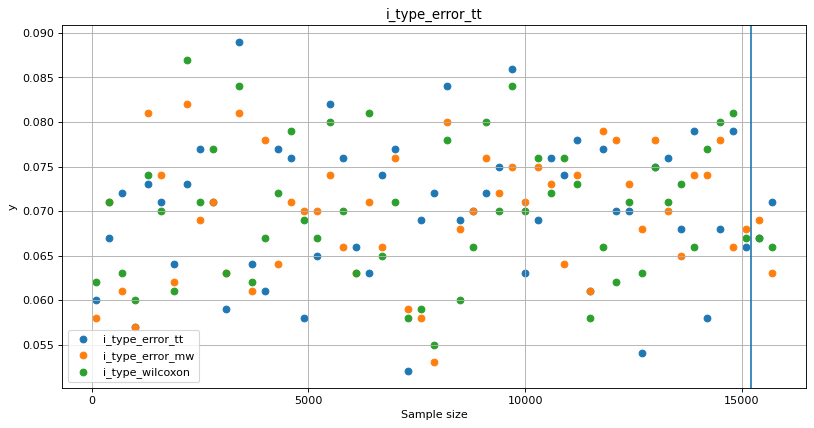

In [7]:
plt.figure(figsize=(12, 6), dpi=80)
plt.scatter(x=res['size'],
            y=res['i_type_error_tt'],
            label = "i_type_error_tt")
plt.scatter(x=res['size'],
            y=res['i_type_error_mw'],
            label = "i_type_error_mw")
plt.scatter(x=res['size'],
            y=res['i_type_wilcoxon'],
            label = "i_type_wilcoxon")
plt.axvline(x=sample_size)
plt.legend()
plt.title('i_type_error_tt')
plt.xlabel("Sample size")
plt.ylabel('y')
plt.grid()
plt.xticks(np.arange(0, res['size'].max(), step=5000))

plt.show()

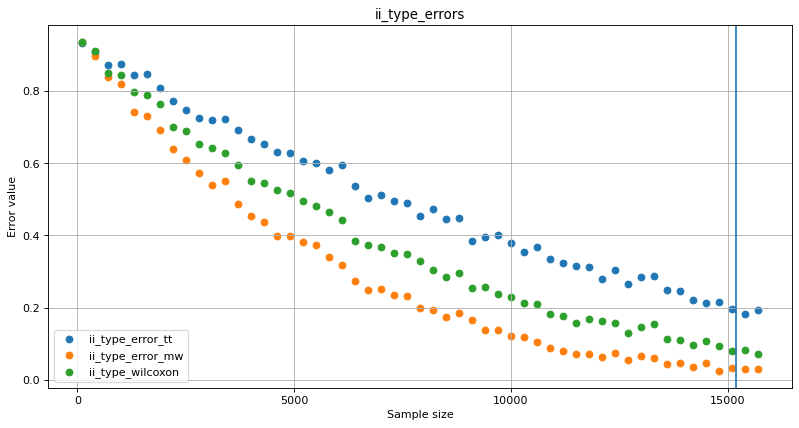

In [8]:
plt.figure(figsize=(12, 6), dpi=80)
plt.scatter(x=res['size'],
            y=res['ii_type_error_tt'],
            label = "ii_type_error_tt")
plt.scatter(x=res['size'],
            y=res['ii_type_error_mw'],
            label = "ii_type_error_mw")
plt.scatter(x=res['size'],
            y=res['ii_type_wilcoxon'],
            label = "ii_type_wilcoxon")
plt.axvline(x=sample_size)
plt.legend()
plt.title('ii_type_errors')
plt.xlabel("Sample size")
plt.ylabel('Error value')
plt.grid()
plt.xticks(np.arange(0, res['size'].max(), step=5000))

plt.show()

### Different sample sizes per group

In [13]:
n_experiments = 1000
coef = 2
start = 100
if sample_size < 2000:
    step = 200
elif sample_size >= 2000 and sample_size< 10000:
    step = 200
elif sample_size >= 10000 and sample_size< 30000:
    step = 300
else:
    step=1000
num=int(sample_size/step)+3

sizes=np.arange(0,num)*step+start
error_per_sample_size = []

for size in sizes:
    print(size)
    i_type_error_tt, i_type_error_mw, i_type_wilcoxon, \
    ii_type_error_tt, ii_type_error_mw, ii_type_wilcoxon = check_stat_errors(size_A=size,
                                                                             size_B=size*coef,
                                                                             n_experiments=n_experiments,
                                                                             MDE=MDE)
    error_per_sample_size.append([size, sample_size, sample_size*coef, i_type_error_tt, i_type_error_mw, \
                                  i_type_wilcoxon, \
        ii_type_error_tt, ii_type_error_mw, ii_type_wilcoxon])

100


<ipython-input-12-7a2e226b74b9>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  experiment_data = np.array([[generator.get_sample(size=size_A),
<ipython-input-12-7a2e226b74b9>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  add_effects = lambda x: np.array([np.array([i[0],


400
700
1000
1300
1600
1900
2200
2500
2800
3100
3400
3700
4000
4300
4600
4900
5200
5500
5800
6100
6400
6700
7000
7300
7600
7900
8200
8500
8800
9100
9400
9700
10000
10300
10600
10900
11200
11500
11800
12100
12400
12700
13000
13300
13600
13900
14200
14500
14800
15100
15400
15700


In [21]:
res = pd.DataFrame(error_per_sample_size, columns = ['recommended_sample_size','size_A', 'size_B', 
                                                     'i_type_error_tt', 'i_type_error_mw', \
                                  'i_type_wilcoxon', \
                                    'ii_type_error_tt', 'ii_type_error_mw', \
                                                     'ii_type_wilcoxon'] )
res[['recommended_sample_size','size_A', 'size_B', 
                                                     'i_type_error_tt', 'i_type_error_mw', \
                                    'ii_type_error_tt', 'ii_type_error_mw']]

,recommended_sample_size,size_A,size_B,i_type_error_tt,i_type_error_mw,ii_type_error_tt,ii_type_error_mw
0,100,15200,30400,0.070,0.072,0.920,0.923
1,400,15200,30400,0.074,0.079,0.882,0.855
2,700,15200,30400,0.055,0.051,0.880,0.830
3,1000,15200,30400,0.064,0.061,0.848,0.785
4,1300,15200,30400,0.075,0.069,0.798,0.699
5,1600,15200,30400,0.080,0.070,0.806,0.687
6,1900,15200,30400,0.076,0.081,0.739,0.589
7,2200,15200,30400,0.076,0.077,0.741,0.592
8,2500,15200,30400,0.062,0.060,0.719,0.542
9,2800,15200,30400,0.070,0.084,0.680,0.496


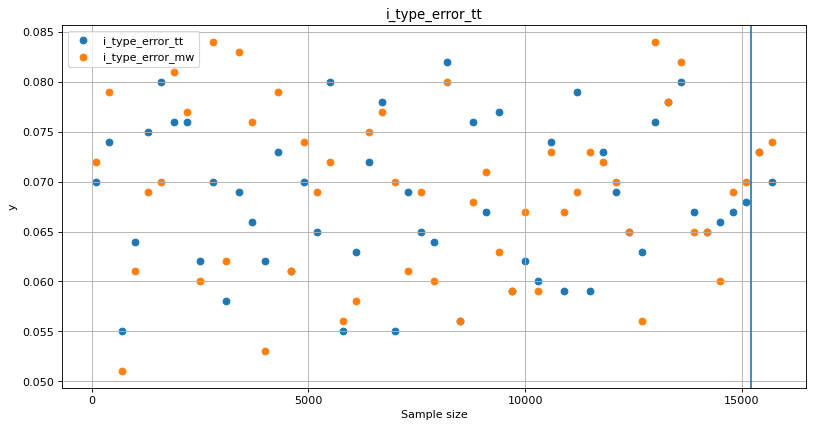

In [18]:
plt.figure(figsize=(12, 6), dpi=80)
plt.scatter(x=res['size_A'],
            y=res['i_type_error_tt'],
            label = "i_type_error_tt")
plt.scatter(x=res['size_A'],
            y=res['i_type_error_mw'],
            label = "i_type_error_mw")
plt.axvline(x=sample_size)
plt.legend()
plt.title('i_type_error_tt')
plt.xlabel("Sample size")
plt.ylabel('y')
plt.grid()
plt.xticks(np.arange(0, res['size_A'].max(), step=5000))

plt.show()

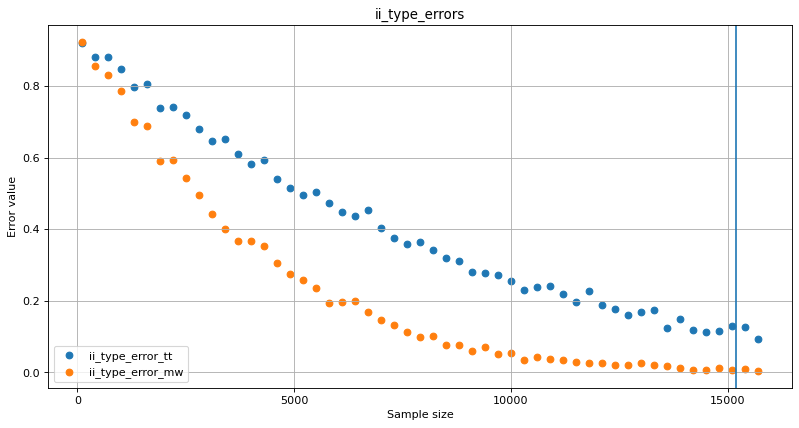

In [19]:
plt.figure(figsize=(12, 6), dpi=80)
plt.scatter(x=res['size_A'],
            y=res['ii_type_error_tt'],
            label = "ii_type_error_tt")
plt.scatter(x=res['size_A'],
            y=res['ii_type_error_mw'],
            label = "ii_type_error_mw")
plt.axvline(x=sample_size)
plt.legend()
plt.title('ii_type_errors')
plt.xlabel("Sample size")
plt.ylabel('Error value')
plt.grid()
plt.xticks(np.arange(0, res['size_A'].max(), step=5000))

plt.show()